In [1]:
import requests
import json
from concurrent.futures import ThreadPoolExecutor
import time
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys

In [2]:
EXCHANGE_LIST = ['UPBIT', 'BINANCE', 'COINBASE', 'OKX']


In [3]:
def get_price(market: str, exchange: str):
    assert market in ['BTC', 'ETH', 'XRP']
    assert exchange in EXCHANGE_LIST

    if exchange == 'UPBIT':
        res = json.loads(requests.get("https://api.upbit.com/v1/ticker",
                         params={"markets": f'KRW-{market},KRW-USDT'}).text)
        krw_price = res[0]['trade_price']
        usdt_rate = res[1]['trade_price']
        return krw_price/usdt_rate
    elif exchange == 'BINANCE':
        res = json.loads(requests.get(
            "https://api.binance.com/api/v3/ticker/price", params={"symbol": f'{market}USDT'}).text)
        price = res['price']

        return float(price)
    elif exchange == 'COINBASE':
        res = json.loads(requests.get(
            f"https://api.exchange.coinbase.com/products/{market}-USDT/ticker").text)
        price = res['price']

        return float(price)
    elif exchange == 'OKX':
        res = json.loads(requests.get(
            f"https://www.okx.com/api/v5/market/index-tickers?instId={market}-USDT").text)
        price = res['data'][0]['idxPx']

        return float(price)


In [4]:
def get_orderbook(market: str):
    assert market in ['BTC', 'ETH', 'XRP']
    res = json.loads(requests.get("https://api.upbit.com/v1/orderbook?level=0",
                      params={"markets": f'KRW-{market}'}).text)
    return res

In [35]:
balance = {'KRW':10000000, 'COIN':0, 'CAN':'BUY'} 
FEE = 0.0005
def trade(action:str, price, bal):
    if action == 'BUY' and bal['CAN'] == 'BUY':
        qty = bal['KRW']/(price*(1+FEE))
        bal = {'KRW':0, 'COIN':qty, 'NET_SNAPSHOT': qty*price, 'LAST_ASK':price, 'CAN':'SELL'}
        print(f"BUY: {bal['NET_SNAPSHOT']:.1f}")
        return bal
    elif action == 'SELL' and bal['CAN'] == 'SELL':
        qty = bal['COIN']
        krw = qty*price*(1-FEE)
        bal = {'KRW':krw, 'COIN':0, 'NET_SNAPSHOT': krw, 'CAN':'BUY'}
        print(f"SELL : {bal['NET_SNAPSHOT']:.1f}")
        return bal
    return bal

In [36]:
recent_prices = []
recent_ratios = []
THRESHOLD = 0.0012
MARKET = 'XRP'
LOADING_COUNT = 60
TIMESTEP = 3
print(f"Loading for {LOADING_COUNT*TIMESTEP} seconds...")
for _ in tqdm(range(LOADING_COUNT)):  # 평균내기 위해 일단 60개 채우기
    with ThreadPoolExecutor(max_workers=10) as pool:
        res = list(pool.map(lambda m: get_price(MARKET, m), EXCHANGE_LIST))

    res = np.array(res)
    ratio_now = res[0] / np.average(res[1:])
    recent_ratios.append(ratio_now)
    recent_prices.append(res)

    time.sleep(TIMESTEP)


recent_prices = np.array(recent_prices)
recent_ratios = np.array(recent_ratios)


orderbooks = []
flag_cnt = 0
cnt = 0 
while True:
    t1 = time.time()
    with ThreadPoolExecutor(max_workers=10) as pool:
        res = list(pool.map(lambda m: get_price(MARKET, m), EXCHANGE_LIST))
    ###

    res = np.array(res)
    ratio_now = res[0] / np.average(res[1:])
    delta = ratio_now - np.average(recent_ratios)

    ####
    buy_flag = 0
    cnt+=1
    orderbook = get_orderbook(MARKET)
    if delta < -THRESHOLD:
        buy_flag = 1
        flag_cnt +=1
        #print(f'BUY FLAG : {flag_cnt}/{cnt}')
        balance = trade('BUY', orderbook[0]['orderbook_units'][0]['ask_price'], balance)
    
    if balance.get('LAST_ASK') is not None:
        bid_price = orderbook[0]['orderbook_units'][0]['bid_price']
        last_ask = balance['LAST_ASK']
        r = (bid_price - last_ask) / last_ask
        if r > 0.0025:
            balance = trade('(+)SELL', bid_price, balance)
        elif r < -0.0015:
            balance = trade('(-)SELL', bid_price, balance) 

    orderbooks.append({
        "buy_flag": buy_flag,
        "orderbook": orderbook,
        "ratio": ratio_now,
        'delta': delta
    })

    recent_prices = np.vstack([recent_prices[1:], res])
    recent_ratios = np.append(recent_ratios[1:], ratio_now)

    time.sleep(TIMESTEP)


Loading for 180 seconds...


100%|██████████| 60/60 [03:19<00:00,  3.33s/it]


BUY: 9995002.5
SELL : 9968934.3
BUY: 9963952.3
SELL : 9982461.4
BUY: 9977472.6
SELL : 9949027.9
BUY: 9944055.9
SELL : 9960044.6
BUY: 9955067.1
SELL : 9972258.3
BUY: 9967274.7


KeyboardInterrupt: 

In [37]:
ask_prices = np.array(list(
    map(lambda x: x['orderbook'][0]['orderbook_units'][0]['ask_price'], orderbooks)))
flags = np.where(np.array(list(map(lambda x: x['buy_flag'], orderbooks))) == 1)


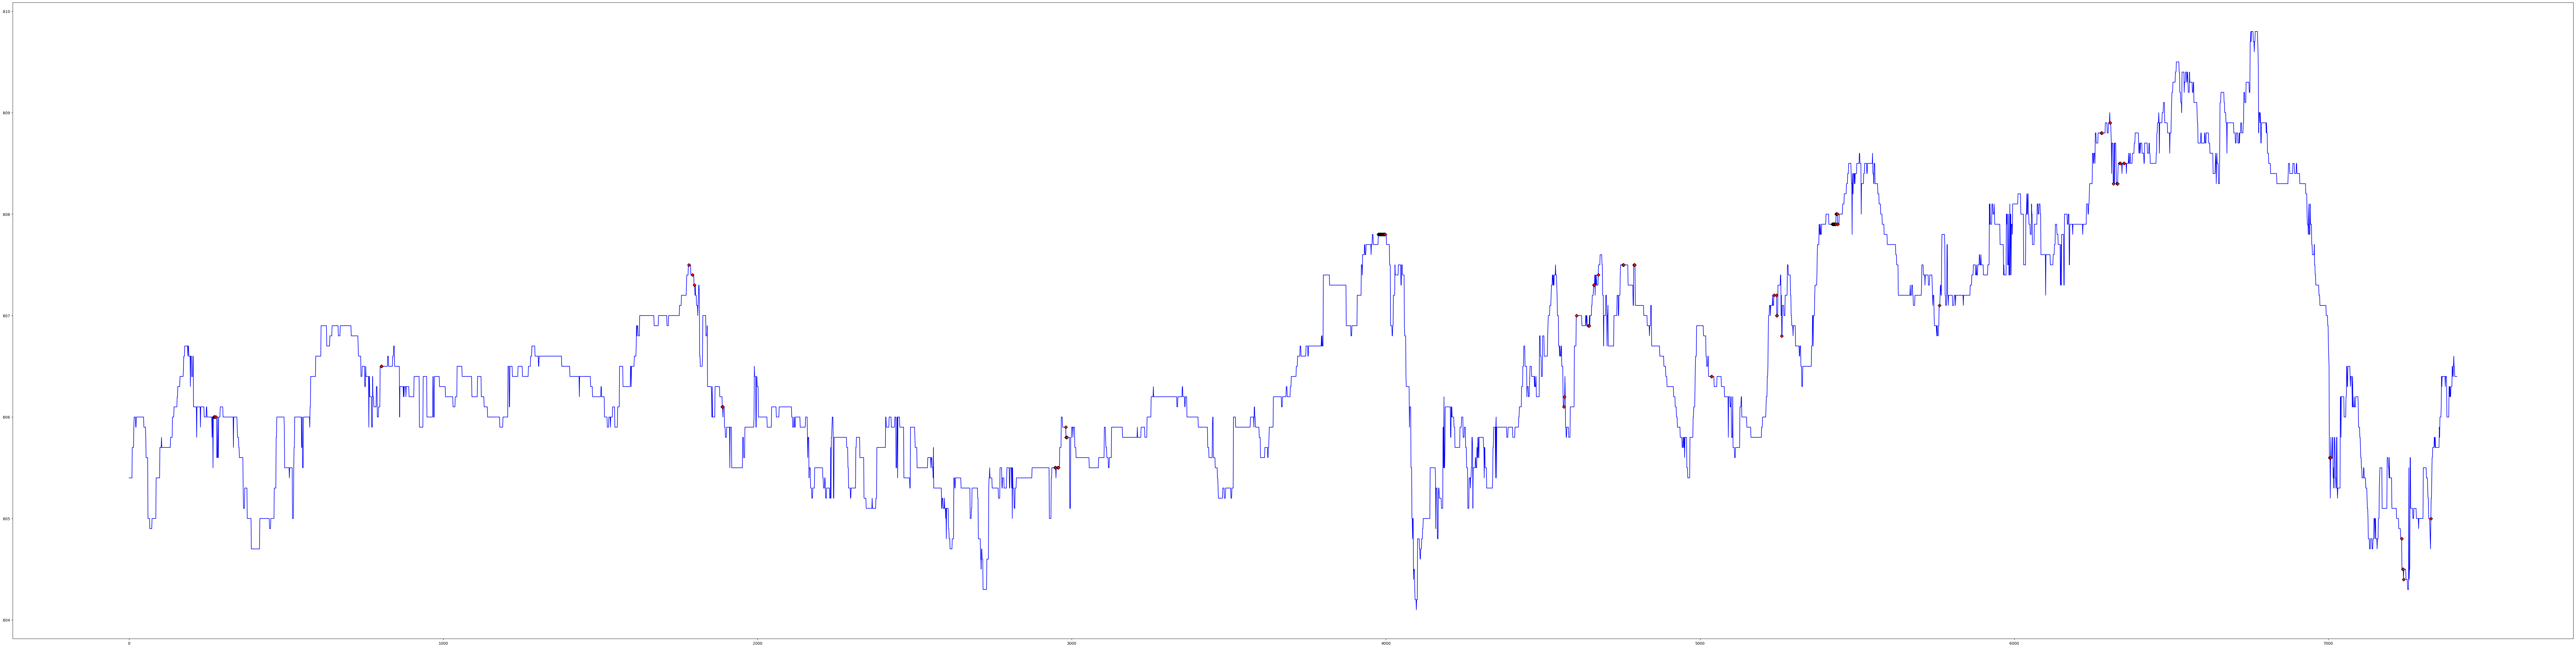

In [38]:
plt.figure(figsize=(120,30))
plt.plot(ask_prices,'-D', markevery=flags[0],c='blue', mfc='red', mec='k')
plt.show()

In [39]:
window = 300
for i in flags[0]:
    if orderbooks[i]['buy_flag'] == 1:
        ask = orderbooks[i]['orderbook'][0]['orderbook_units'][0]['ask_price']
        max_bid = max([o['orderbook'][0]['orderbook_units'][0]
                      ['bid_price'] for o in orderbooks[i:i+window]])
        delta = orderbooks[i]['delta']
        print(f"{delta:.6f} {i:4d}, {ask:.1f} {'>' if ask>max_bid else '<'} {max_bid:.1f}, {(max_bid - ask)-0.0005*(max_bid+ask): .4f}")
        print(f"가격 상승 퍼센트 : {(max_bid-ask)/ask*100:.3f}%")


-0.001211  270, 806.0 < 806.0, -0.8060
가격 상승 퍼센트 : 0.000%
-0.001310  271, 806.0 < 806.0, -0.8060
가격 상승 퍼센트 : 0.000%
-0.001295  272, 806.0 < 806.0, -0.8060
가격 상승 퍼센트 : 0.000%
-0.001223  273, 806.0 < 806.0, -0.8060
가격 상승 퍼센트 : 0.000%
-0.001277  276, 806.0 < 806.0, -0.8060
가격 상승 퍼센트 : 0.000%
-0.001258  803, 806.5 < 806.5, -0.8065
가격 상승 퍼센트 : 0.000%
-0.001215  804, 806.5 < 806.5, -0.8065
가격 상승 퍼센트 : 0.000%
-0.001251 1782, 807.5 > 806.8, -1.5072
가격 상승 퍼센트 : -0.087%
-0.001335 1793, 807.4 > 806.8, -1.4071
가격 상승 퍼센트 : -0.074%
-0.001350 1799, 807.3 > 806.8, -1.3070
가격 상승 퍼센트 : -0.062%
-0.001515 1888, 806.1 > 806.0, -0.9061
가격 상승 퍼센트 : -0.012%
-0.001423 1889, 806.1 > 806.0, -0.9061
가격 상승 퍼센트 : -0.012%
-0.001573 2947, 805.5 < 805.8, -0.5057
가격 상승 퍼센트 : 0.037%
-0.001543 2949, 805.5 < 805.8, -0.5057
가격 상승 퍼센트 : 0.037%
-0.001437 2956, 805.5 < 805.8, -0.5057
가격 상승 퍼센트 : 0.037%
-0.001391 2957, 805.5 < 806.0, -0.3057
가격 상승 퍼센트 : 0.062%
-0.001346 2958, 805.5 < 806.0, -0.3057
가격 상승 퍼센트 : 0.062%
-0.001648

In [36]:
window = 300
for i in flags[0]:
    if orderbooks[i]['buy_flag'] == 1:
        ask = orderbooks[i]['orderbook'][0]['orderbook_units'][0]['ask_price']
        max_bid = max([o['orderbook'][0]['orderbook_units'][0]
                      ['bid_price'] for o in orderbooks[i:i+window]])
        min_bid = min([o['orderbook'][0]['orderbook_units'][0]
                      ['bid_price'] for o in orderbooks[i:i+window]])
        delta = orderbooks[i]['delta']
        print(f"가격 퍼센트 범위 : {(min_bid-ask)/ask*100:.3f}%  ~ {(max_bid-ask)/ask*100:.3f}%")


가격 퍼센트 범위 : -0.062%  ~ 0.298%
가격 퍼센트 범위 : -0.062%  ~ 0.298%
가격 퍼센트 범위 : -0.062%  ~ 0.298%
가격 퍼센트 범위 : -0.062%  ~ 0.298%
가격 퍼센트 범위 : -0.062%  ~ 0.298%
가격 퍼센트 범위 : -0.062%  ~ 0.298%
가격 퍼센트 범위 : -0.062%  ~ 0.298%
가격 퍼센트 범위 : -0.062%  ~ 0.298%
가격 퍼센트 범위 : -0.062%  ~ 0.298%
가격 퍼센트 범위 : -0.062%  ~ 0.298%
가격 퍼센트 범위 : -0.025%  ~ 0.236%
가격 퍼센트 범위 : -0.062%  ~ 0.198%
가격 퍼센트 범위 : -0.149%  ~ -0.037%
가격 퍼센트 범위 : -0.112%  ~ 0.149%
가격 퍼센트 범위 : -0.112%  ~ 0.149%
가격 퍼센트 범위 : -0.025%  ~ 0.272%
가격 퍼센트 범위 : -0.025%  ~ 0.260%
가격 퍼센트 범위 : -0.012%  ~ 0.260%
가격 퍼센트 범위 : -0.012%  ~ 0.260%
가격 퍼센트 범위 : -0.160%  ~ 0.111%
가격 퍼센트 범위 : -0.148%  ~ 0.123%
가격 퍼센트 범위 : -0.148%  ~ 0.123%
가격 퍼센트 범위 : -0.148%  ~ 0.123%
가격 퍼센트 범위 : -0.123%  ~ -0.012%
가격 퍼센트 범위 : -0.123%  ~ -0.012%
가격 퍼센트 범위 : -0.123%  ~ -0.012%
가격 퍼센트 범위 : -0.099%  ~ 0.012%
가격 퍼센트 범위 : -0.049%  ~ 0.173%
가격 퍼센트 범위 : -0.049%  ~ 0.173%
가격 퍼센트 범위 : -0.296%  ~ 0.099%
가격 퍼센트 범위 : -0.296%  ~ 0.099%
가격 퍼센트 범위 : -0.296%  ~ 0.099%
가격 퍼센트 범위 : -0.296%  ~ 0.099%
가격 퍼센트

In [37]:
flags

(array([ 124,  125,  126,  127,  128,  130,  131,  132,  133,  135,  477,
         478, 1050, 1845, 1853, 2577, 2582, 2604, 2605, 2896, 2897, 2898,
        2899, 3087, 3088, 3089, 3090, 3192, 3194, 3578, 3580, 3581, 3582,
        3648, 3649, 3650, 3651, 3655, 3656, 3658, 3660, 3889, 3890, 3895,
        3896, 3897, 3898, 3899, 3902, 3903, 3906, 3907]),)